# Comparing torch & TF2 implementations: RandomNN

Comparing NN-INF performances on synthetic function optimization.

See `exp_sim_optim_simple.py` for base code.

In [1]:
from exp_sim_optim_simple import (
    setup_objective,
    run_sim_optim_gp,
    run_sim_optim_torch,
    run_sim_optim_tf2,
    eval_hook,
    report_result,
    plot_regrets,
    plot_surface,
)

import numpy as np
import torch
import tensorflow as tf

In [2]:
print("torch:", torch.__version__)
print("tensorflow:", tf.__version__)

torch: 1.7.1
tensorflow: 2.4.1


## Problem: Finding Minimum of a Random Neural Network

Find the minimizer of a 5-layer random neural network.

In [3]:
np.random.seed(1)
torch.manual_seed(2)
tf.random.set_seed(3)

In [4]:
# Common arguments
input_dim = 2
init_points = 1
max_iter = 100

# NN specific arguments
n_layers = 5
n_units = 64
activation = "relu"
bound = 10.0
initializer = torch.nn.init.xavier_uniform_

In [5]:
problem, domain, X, Y = setup_objective(
    "RandomNN", 
    input_dim,
    init_points,
    n_layers=n_layers, 
    n_units=n_units,
    activation=activation,
    bound=bound,
    initializer=initializer,
)
print(problem)

RandomNN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


## Baseline: GP-LCB

minimum: 0.26906025409698486
minimizer: [1.05409207 3.81548674]
elapsed time: 43.41 seconds


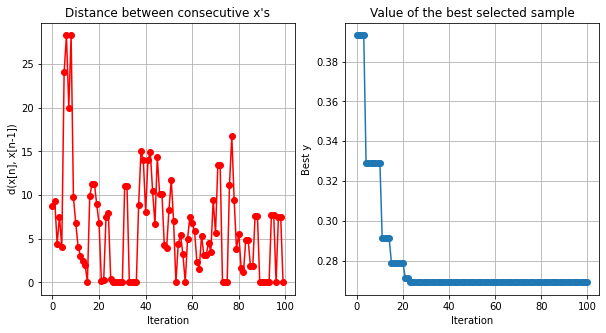

In [6]:
# ~45 seconds on laptop
gp_opt = run_sim_optim_gp(
    problem,
    domain,
    X,
    Y,
    max_iter=max_iter,
    acquisition_type="LCB",
)

## NN-INF (torch)

In [7]:
# Size of NN estimator
layer_sizes = [8, 8, 4]

Optimizing:   1%|          | 1/100 [00:00<00:10,  9.17it/s, R_i=0.451, exp_w=1.27, f*hat=0.721, fhat_i=0.721, r_i=0.451, t_i=0.112, y_i=0.721, μ*=0.558, σ*=0.12]

FCNet(
  (fc_0): Linear(in_features=2, out_features=8, bias=True)
  (fc_1): Linear(in_features=8, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=4, bias=True)
  (fc_last): Linear(in_features=4, out_features=1, bias=True)
  (scale): Linear(in_features=1, out_features=1, bias=True)
)
Models printout after each iteration is only available for GP and GP_MCMC models


Optimizing: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s, R_i=0.423, exp_w=48.1, f*hat=0.693, fhat_i=0.693, r_i=0.423, t_i=0.305, y_i=0.693, μ*=0.692, σ*=0.00219]


Elapsed Time: 31.75s
predicted minimum value: 0.6437952518463135 +/- 0.0008657995495013893
predicted minimizer: [ 3.47836376 -6.84697816]
actual value at predicted minimizer: 0.6433571577072144


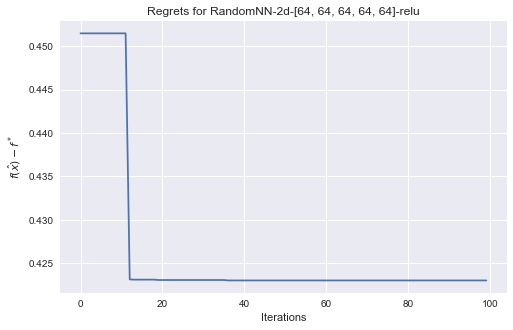

In [8]:
# ~45 seconds
nninf_torch = run_sim_optim_torch(
    problem,
    domain,
    layer_sizes=layer_sizes,
    max_iter=max_iter,
)

## NN-INF (tf2)

Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 137
Trainable params: 137
Non-trainable params: 0
_________________________________________________________________
Models printout after each iteration is only available for GP and GP_MCMC models


Optimizing: 100%|██████████| 100/100 [02:19<00:00,  1.40s/it, R_i=1.03, exp_w=48.1, f*hat=1.3, fhat_i=1.3, r_i=1.03, t_i=1.29, y_i=1.3, μ*=1.3, σ*=6.41e-6] 

Elapsed Time: 139.69s
predicted minimum value: 1.2932696342468262 +/- 1.7517922970000654e-05
predicted minimizer: [-0.12740013  8.41730981]
actual value at predicted minimizer: 0.4022979140281677


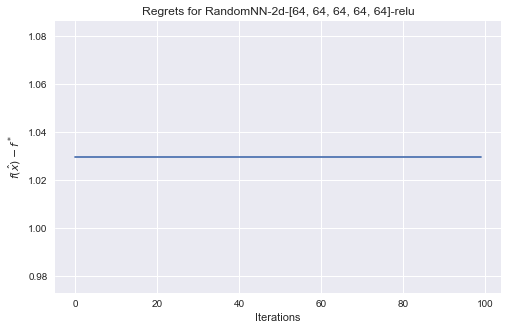

In [9]:
# ~250 seconds
nninf_tf2 = run_sim_optim_tf2(
    problem,
    domain,
    layer_sizes=layer_sizes,    
    max_iter=max_iter,
)

## Combined Results

In [10]:
title = f"Random {n_layers}-Layer NN ({activation}, xavier init.)"

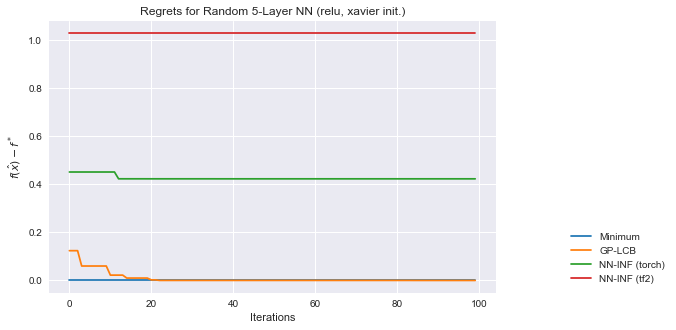

In [11]:
plot_regrets(
    [np.repeat(0, max_iter), 
     gp_opt.Y_best[-max_iter:] - problem.fmin, 
     nninf_torch["regrets"], 
     nninf_tf2["regrets"]],
    title, 
    ["Minimum", "GP-LCB", "NN-INF (torch)", "NN-INF (tf2)"],
)

Grid Search     : min 0.26973 at [1.1111114 3.939394 ]
GP-LCB          : min 0.26906 at [1.05409207 3.81548674]
NN-INF (torch)  : min 0.64336 at [ 3.47836376 -6.84697816]
NN-INF (tf2)    : min 0.40230 at [-0.12740013  8.41730981]


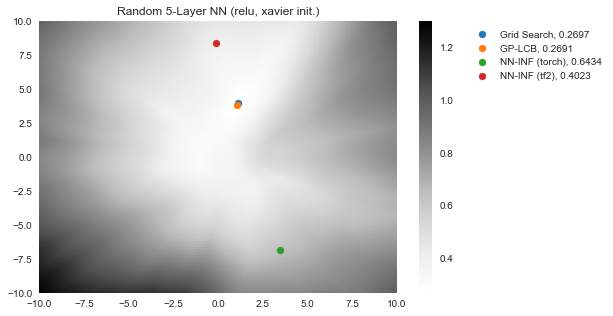

In [12]:
# NN Surface
minimizers = [
    (problem.min, problem.fmin, "Grid Search"),
    (gp_opt.x_opt, gp_opt.fx_opt, "GP-LCB"),
    (nninf_torch["bo"].x_opt, nninf_torch["bo"].fx_opt, "NN-INF (torch)"),
    (nninf_tf2["bo"].x_opt, nninf_tf2["bo"].fx_opt, "NN-INF (tf2)"),
]

plot_surface(problem, bound, minimizers, title)